In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from dask.distributed import Client
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [20]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [21]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [22]:
train.dtypes

id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

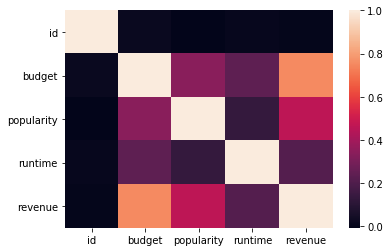

In [23]:
sns.heatmap(train.corr())

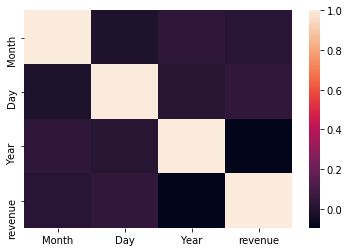

In [24]:
train[['Month','Day', 'Year']] = train['release_date'].str.split('/',expand=True)
trainset_release_date = train[['Month', 'Day', 'Year', 'revenue']]

trainset_release_date = trainset_release_date.astype(float)

cor = trainset_release_date.corr()

sns.heatmap(cor)

train = train.drop(['Year'], axis=1)



In [25]:
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
Month                       0
Day                         0
dtype: int64

In [26]:
runtime_mean = train['runtime'].mean()
print(runtime_mean)
train['runtime'] = train['runtime'].replace(0, runtime_mean)

train['homepage'] = train['homepage'].fillna(0)
train.loc[train['homepage'] != 0, 'homepage'] = 1

107.85657104736491


In [27]:
# Using function "from https://www.kaggle.com/tijlkindt/simple-tmdb-prediction-with-linear-regression - Simple TMDB prediction with Linear Regression" for JSON Treatment 

def proc_json(string, key):
    try:
        data = eval(string)
        return ",".join([d[key] for d in data])
    except:
        return ''

def proc_json_len(string):
    try:
        data = eval(string)
        return len(data)
    except:
        return 0


train.belongs_to_collection = train.belongs_to_collection.apply(lambda x: proc_json(x, 'name'))

train.genres = train.genres.apply(lambda x: proc_json(x, 'name'))

train.production_companies = train.production_companies.apply(lambda x: proc_json(x, 'name'))

train.production_countries = train.production_countries.apply(lambda x: proc_json(x, 'iso_3166_1'))

train.spoken_languages = train.spoken_languages.apply(lambda x: proc_json(x, 'iso_639_1'))

train.Keywords = train.Keywords.apply(lambda x: proc_json(x, 'name'))

train.cast = train.cast.apply(proc_json_len)

train.crew = train.crew.apply(proc_json_len)


In [28]:
#Genres

genres = []
for idx, val in train.genres.iteritems():
    gen_list = val.split(',')
    for gen in gen_list:
        if gen == '':
            continue

        if gen not in genres:
            genres.append(gen)
            

genre_column_names = []
for gen in genres:
    col_name = 'genres' + gen.replace(' ', '_')
    train[col_name] = train.genres.str.contains(gen).astype('uint8')
    genre_column_names.append(col_name)

train.drop(['genres'], axis=1)

,id,belongs_to_collection,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Month,Day,genresComedy,genresDrama,genresFamily,genresRomance,genresThriller,genresAction,genresAnimation,genresAdventure,genresHorror,genresDocumentary,genresMusic,genresCrime,genresScience_Fiction,genresMystery,genresForeign,genresFantasy,genresWar,genresWestern,genresHistory,genresTV_Movie
0,1,Hot Tub Time Machine Collection,14000000,0,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"Paramount Pictures,United Artists,Metro-Goldwy...",US,2/20/15,93.0,en,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"time travel,sequel,hot tub,duringcreditsstinger",24,72,12314651,2,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,The Princess Diaries Collection,40000000,0,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,Walt Disney Pictures,US,8/6/04,113.0,en,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"coronation,duty,marriage,falling in love",20,9,95149435,8,6,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,,3300000,1,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"Bold Films,Blumhouse Productions,Right of Way ...",US,10/10/14,105.0,en,Released,The road to greatness can take you to the edge.,Whiplash,"jazz,obsession,conservatory,music teacher,new ...",51,64,13092000,10,10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,,1200000,1,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,,IN,3/9/12,122.0,"en,hi",Released,NaN,Kahaani,"mystery,bollywood,police corruption,crime,indi...",7,3,16000000,3,9,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,,0,0,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,,KR,2/5/09,118.0,ko,Released,NaN,Marine Boy,,4,2,3923970,2,5,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,,8000000,0,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,/6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg,,,8/6/87,83.0,en,Released,NaN,Pinocchio and the Emperor of the Night,,4,11,3261638,8,6,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
6,7,,14000000,1,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,/4QjzFuaZmB4btGnLwAgdp23BzIU.jpg,"Ghost House Pictures,North Box Productions","US,CA",8/30/12,92.0,en,Released,Fear The Demon That Doesn't Fear God,The Possession,,14,77,85446075,8,30,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,8,,0,0,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,/83BV8fGy5p9i8RwE9oj76tZ1Ikp.jpg,,,1/15/04,84.0,"ar,en",Released,Different channels. Different truths.,Control Room,"journalism,translation,television,manipulation...",4,1,2586511,1,15,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,9,The Muppet Collection,0,0,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,/5A8gKzOrF9Z7tSUX6xd5dEx4NXf.jpg,"Walt Disney Pictures,Jim Henson Productions,Ji...",US,2/16/96,100.0,en,Released,Set sail for Muppet mayhem!,Muppet Treasure Island,"island,pirate gang,puppet,treasure hunt",12,8,34327391,2,16,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
9,10,,6000000,0,tt0310281,en,A Mighty Wind,"In ""A Mighty Wind"", director Christopher Guest...",4.672036,/xwD4EsPOGLuKP50Q1gwqAsyhAFB.jpg,Castle Rock Entertainment,US,4/16/03,91.0,en,Released,"Back together for the first time, again.",A Mighty Wind,"mockumentary,folk singer",20,11,18750246,4,16,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [29]:
#Target Encoding for categorical variables


means = train.groupby('overview')['revenue'].mean()
train['overview'] = train['overview'].map(means)

means = train.groupby('Keywords')['revenue'].mean()
train['Keywords'] = train['Keywords'].map(means)

means = train.groupby('original_language')['revenue'].mean()
train['original_language'] = train['original_language'].map(means)

means = train.groupby('original_title')['revenue'].mean()
train['original_title'] = train['original_title'].map(means)

means = train.groupby('production_countries')['revenue'].mean()
train['production_countries'] = train['production_countries'].map(means)

means = train.groupby('production_companies')['revenue'].mean()
train['production_companies'] = train['production_companies'].map(means)

means = train.groupby('status')['revenue'].mean()
train['status'] = train['status'].map(means)

means = train.groupby('original_title')['revenue'].mean()
train['original_title'] = train['original_title'].map(means)

In [30]:
#Dropping least important features

train = train.drop(['belongs_to_collection', 'genres', 'imdb_id', 'poster_path', 'release_date', 'spoken_languages', 'tagline', 'title'], axis=1)

train = train.astype(np.float64)

In [16]:
#Using TPOT for model selection with Dask support

#client = Client(n_workers=4, threads_per_worker=1)
#client


#trainset_features = train.drop(['revenue'], axis=1).values
#trainset_target = train['revenue'].values

#X_train, X_test, y_train, y_test = train_test_split(trainset_features, trainset_target, train_size=0.75, test_size=0.25)


#tp = TPOTClassifier(generations=5, n_jobs=-1, random_state=0, verbosity=2, use_dask=True)

#tp.fit(X_train, y_train)

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [31]:
trainset_features = train.drop(['revenue'], axis=1)
trainset_target = train['revenue']

X_train, X_test, y_train, y_test = train_test_split(trainset_features, trainset_target,
                                                    train_size=0.75, test_size=0.25)


gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)


y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)


print('Feature importances:', list(gbm.feature_importances_))

estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

[1]	valid_0's l1: 7.1376e+07	valid_0's l2: 1.45414e+16
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 6.78089e+07	valid_0's l2: 1.31821e+16
[3]	valid_0's l1: 6.44488e+07	valid_0's l2: 1.19813e+16
[4]	valid_0's l1: 6.12681e+07	valid_0's l2: 1.08986e+16
[5]	valid_0's l1: 5.82293e+07	valid_0's l2: 9.91351e+15
[6]	valid_0's l1: 5.53172e+07	valid_0's l2: 9.00676e+15
[7]	valid_0's l1: 5.258e+07	valid_0's l2: 8.19177e+15
[8]	valid_0's l1: 4.99769e+07	valid_0's l2: 7.4617e+15
[9]	valid_0's l1: 4.74964e+07	valid_0's l2: 6.7874e+15
[10]	valid_0's l1: 4.51465e+07	valid_0's l2: 6.18397e+15
[11]	valid_0's l1: 4.29131e+07	valid_0's l2: 5.63732e+15
[12]	valid_0's l1: 4.0784e+07	valid_0's l2: 5.1392e+15
[13]	valid_0's l1: 3.87681e+07	valid_0's l2: 4.69965e+15
[14]	valid_0's l1: 3.68488e+07	valid_0's l2: 4.29254e+15
[15]	valid_0's l1: 3.50249e+07	valid_0's l2: 3.92443e+15
[16]	valid_0's l1: 3.32903e+07	valid_0's l2: 3.59122e+15
[17]	valid_0's l1: 3.16311e+07	valid_0's l2

In [32]:
#Making validation Regression with best parameters

lr = LGBMRegressor(boosting_type='dart',num_leaves=20,max_depth=-1,min_data_in_leaf=20, learning_rate=0.2,n_estimators=500,subsample_for_bin=200000,
                   class_weight=None,min_split_gain=0.0,min_child_weight=0.001,subsample=0.1,subsample_freq=0,colsample_bytree=0.75,reg_alpha=0.0,reg_lambda=0.0,
                   random_state=101,n_jobs=-1)

lr.fit(X_train, y_train,eval_set=[(X_test, y_test)])
pred = lr.predict(X_test, num_iteration=lr.best_iteration_)

[1]	valid_0's l2: 1.05634e+16
[2]	valid_0's l2: 7.03825e+15
[3]	valid_0's l2: 4.76593e+15
[4]	valid_0's l2: 3.2476e+15
[5]	valid_0's l2: 2.26987e+15
[6]	valid_0's l2: 1.63307e+15
[7]	valid_0's l2: 1.23542e+15
[8]	valid_0's l2: 9.61774e+14
[9]	valid_0's l2: 7.82528e+14
[10]	valid_0's l2: 1.00693e+15
[11]	valid_0's l2: 8.1113e+14
[12]	valid_0's l2: 6.79227e+14
[13]	valid_0's l2: 5.94962e+14
[14]	valid_0's l2: 5.3471e+14
[15]	valid_0's l2: 6.03997e+14
[16]	valid_0's l2: 5.30833e+14
[17]	valid_0's l2: 5.91494e+14
[18]	valid_0's l2: 5.88855e+14
[19]	valid_0's l2: 5.12454e+14
[20]	valid_0's l2: 4.64207e+14
[21]	valid_0's l2: 4.3744e+14
[22]	valid_0's l2: 4.51497e+14
[23]	valid_0's l2: 4.72345e+14
[24]	valid_0's l2: 4.39462e+14
[25]	valid_0's l2: 4.19388e+14
[26]	valid_0's l2: 4.02831e+14
[27]	valid_0's l2: 4.71311e+14
[28]	valid_0's l2: 9.49248e+14
[29]	valid_0's l2: 7.52476e+14
[30]	valid_0's l2: 6.21643e+14
[31]	valid_0's l2: 6.17629e+14
[32]	valid_0's l2: 5.34323e+14
[33]	valid_0's l2: 4.

[265]	valid_0's l2: 3.24016e+14
[266]	valid_0's l2: 3.20073e+14
[267]	valid_0's l2: 3.13646e+14
[268]	valid_0's l2: 3.17626e+14
[269]	valid_0's l2: 3.11777e+14
[270]	valid_0's l2: 3.16369e+14
[271]	valid_0's l2: 3.20278e+14
[272]	valid_0's l2: 3.12577e+14
[273]	valid_0's l2: 3.16319e+14
[274]	valid_0's l2: 3.20547e+14
[275]	valid_0's l2: 3.12799e+14
[276]	valid_0's l2: 3.06988e+14
[277]	valid_0's l2: 3.01749e+14
[278]	valid_0's l2: 3.09473e+14
[279]	valid_0's l2: 3.13601e+14
[280]	valid_0's l2: 3.15242e+14
[281]	valid_0's l2: 3.18432e+14
[282]	valid_0's l2: 3.24731e+14
[283]	valid_0's l2: 3.30653e+14
[284]	valid_0's l2: 3.33952e+14
[285]	valid_0's l2: 3.22712e+14
[286]	valid_0's l2: 3.26822e+14
[287]	valid_0's l2: 3.19229e+14
[288]	valid_0's l2: 3.13637e+14
[289]	valid_0's l2: 3.17507e+14
[290]	valid_0's l2: 3.21038e+14
[291]	valid_0's l2: 3.15263e+14
[292]	valid_0's l2: 3.10112e+14
[293]	valid_0's l2: 3.11263e+14
[294]	valid_0's l2: 3.05843e+14
[295]	valid_0's l2: 3.07766e+14
[296]	va

In [ ]:
#Submission

#submit = pd.DataFrame({'id': test.id, 'revenue':np.expm1(predict)})
#submit.to_csv('submission.csv', index=False)
